# Big Data tutorial
## Finding the "needle in the haystack" galaxies 

In [2]:
#install python libraries that are needed
#!pip install dataclasses # needed as python is a lower version than code needs
#!pip install astropy # general purpose astronomy library
#!pip install photutils # photomertry genreal purpose library
#!pip install scikit-image # image anaylsis genral purpose library
#!pip install tqdm

import pawlikMorphLSST as pmlsst
print("Galaxy analysis code imported")

# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs # query with CasJobs
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                  # standard Python lib for math ops
import pandas as pd                       # data manipulation package
import matplotlib.pyplot as plt     # another graphing package
from pathlib import Path            # manage local files in your Compute containers
from astropy.visualization import ZScaleInterval # for plotting clear images
from tqdm import tqdm_notebook # for a nice progress bar
from concurrent.futures import ProcessPoolExecutor

print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)

# for plotting clear images
zscale = ZScaleInterval()

# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Galaxy analysis code imported
SciServer libraries imported
Supporting libraries imported
Settings applied


In [3]:
# Find objects in the Sloan Digital Sky Survey's.
#
# Query the Sloan Digital Sky Serveys' NSA catalog of galactical objects.
# For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx?cmd=description+nsatlas+U#&&history=description+nsatlas+U
#
# This query finds all galaxies with a brightness less than 17.7 and greater than 14.5, and a z, 0.01 > z > 0.05
# 
# First, store the query in an object called "query"
query="""
select distinct p.*, m.objra, m.objdec
from dbo.PawlikMorph p
  join dbo.mangaDAPall m
  on m.mangaID = p.mangaid and m.plateifu = p.plateifu
  where p.warningflag = 0 and p.A > -99 and p.S > -99 and p.C2080 > -99 and p.C5090 > -99
"""

#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")

SQL query finished.


In [40]:
def makename(df):
    root = "/home/idies/workspace/sdss_das/das2/imaging/"
    #run/rerun/corr/camccol/fpC-run-rcamcol-field.fit.gz"
    df["fname"] = df.apply(lambda row: root + f"{row.run}/{row.rerun}/corr/{row.camcol}/fpC-{row.run:06}-r{row.camcol}-{row.field:04}.fit.gz", axis=1)
    return df
#add filename column
all_gals = makename(all_gals)
# View the information of the first 10 galaxies retrieved
all_gals[0:10]

,mangaID,plateifu,run,rerun,camcol,field,imgsize,imgmin,imgmax,skybgr,...,sb0,sb0err,reff,refferr,n,nerr,warningflag,objra,objdec,fname
0,1-109056,8077-6103,2738,40,4,182,141,151,995,174.657,...,42.76620,0.691951,8.22229,0.069364,1.62616,0.016532,0,39.446587,0.405085,/home/idies/workspace/sdss_das/das2/imaging/2738/40/corr/4/fpC-002738-r4-0182.fit.gz
1,1-109073,8078-12704,2738,40,2,200,141,149,462,173.479,...,10.24820,0.309060,15.05300,0.256780,1.52435,0.028224,0,42.156776,-0.554293,/home/idies/workspace/sdss_das/das2/imaging/2738/40/corr/2/fpC-002738-r2-0200.fit.gz
2,1-109167,8078-1902,2738,40,2,200,141,155,3471,174.796,...,32.39330,0.678778,11.80380,0.135262,3.51242,0.016146,0,42.216927,-0.524053,/home/idies/workspace/sdss_das/das2/imaging/2738/40/corr/2/fpC-002738-r2-0200.fit.gz
3,1-109234,9193-1901,3325,41,5,415,141,83,865,100.106,...,27.42260,1.088020,5.45669,0.110598,1.91564,0.039872,0,45.997425,0.426382,/home/idies/workspace/sdss_das/das2/imaging/3325/41/corr/5/fpC-003325-r5-0415.fit.gz
4,1-109244,8080-12702,3325,41,1,428,141,85,767,101.879,...,9.22178,0.148470,29.41020,0.286122,2.46300,0.015745,0,47.999416,-1.161661,/home/idies/workspace/sdss_das/das2/imaging/3325/41/corr/1/fpC-003325-r1-0428.fit.gz
5,1-109250,8080-1902,3325,41,1,427,141,81,900,99.657,...,21.59720,0.986447,6.24776,0.150909,2.60848,0.041540,0,47.785259,-1.054341,/home/idies/workspace/sdss_das/das2/imaging/3325/41/corr/1/fpC-003325-r1-0427.fit.gz
6,1-109308,8082-12704,3325,41,3,441,141,84,632,102.073,...,3.58897,0.164881,26.72530,0.771160,2.72491,0.041843,0,49.949562,-0.221145,/home/idies/workspace/sdss_das/das2/imaging/3325/41/corr/3/fpC-003325-r3-0441.fit.gz
7,1-109356,8081-3703,3325,41,5,442,141,83,547,100.243,...,45.32370,0.425476,8.40506,0.039488,1.07560,0.009232,0,50.073841,0.523632,/home/idies/workspace/sdss_das/das2/imaging/3325/41/corr/5/fpC-003325-r5-0442.fit.gz
8,1-109378,8084-12703,3325,41,2,450,141,80,810,97.623,...,9.60244,0.148755,31.13280,0.294098,2.51930,0.015023,0,51.169918,-0.681473,/home/idies/workspace/sdss_das/das2/imaging/3325/41/corr/2/fpC-003325-r2-0450.fit.gz
9,1-109392,8085-6101,2738,40,3,258,141,164,3189,185.235,...,6.04365,0.114207,42.68880,0.516910,3.99316,0.014490,0,50.922337,-0.117034,/home/idies/workspace/sdss_das/das2/imaging/2738/40/corr/3/fpC-002738-r3-0258.fit.gz


Text(0.5, 1.0, 'Galaxy positions')

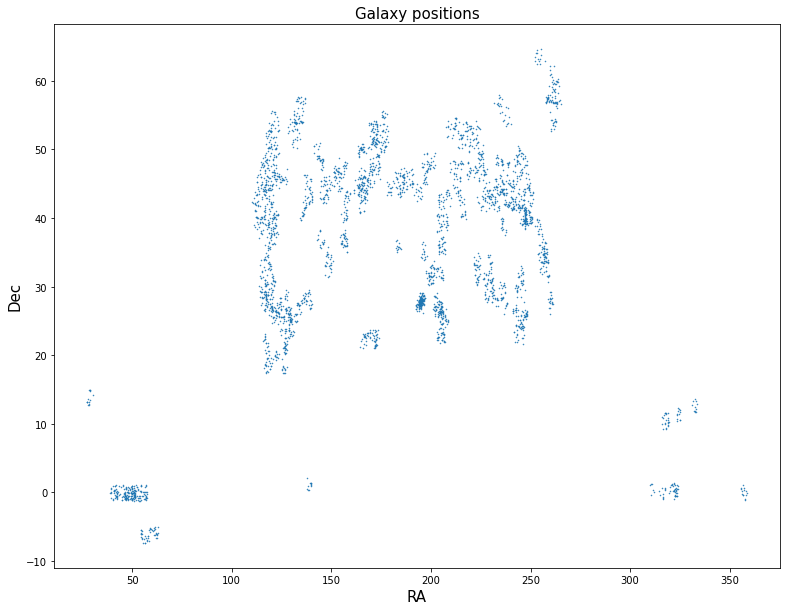

In [5]:
#plot all the galaxies retreived
plt.figure(figsize=(13,10))
plt.scatter(all_gals["objra"], all_gals["objdec"], s=1, marker=".")
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions', fontsize=15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99b3152320>,
      dtype=object)

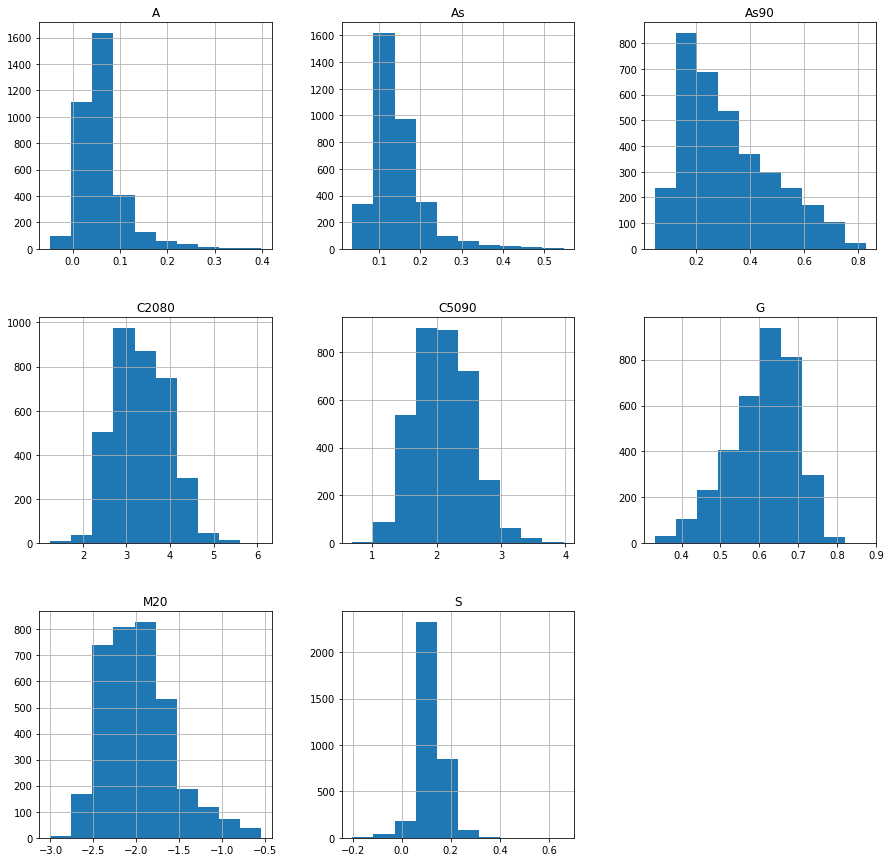

In [6]:
all_gals.hist(column=["As", "A", "G", "As90", "M20", "S", "C2080", "C5090"],figsize=(15,15))

In [7]:
# Need to use the information retrieved from the catalogue to form path to the images stored on SciServer

filenames = []
rootpath = Path("/home/idies/workspace/sdss_das/das2/imaging/")
# Only certain folders contain the correct images
validnames = [str(i) for i in range(40, 50)]
for i in range(len(all_gals)):
    # get a row from the dataframe
    row = all_gals.iloc[i]
    # get the telescope parameters that define an image
    run, rerun, camcol, field = int(row["run"]), int(row["rerun"]), int(row["camcol"]), int(row["field"])
    # get the position of the galaxy ion the image
    ra, dec = row["objra"], row["objdec"]
    path = rootpath / f"{run}/"
    subdirs = path.glob("*")
    path = None
    for subdir in subdirs:
        if subdir.stem in validnames:
            path = subdir
            continue
    if path is None:
        continue
    filename = f"corr/{camcol}/fpC-{run:06}-r{camcol}-{field:04}.fit.gz"
    fullname = path / filename
    # store filename, and position of galaxy in image
    filenames.append([fullname, ra, dec])

In [ ]:
# display some galaxies in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

axs = axs.ravel()
i = 0
idx = 0
while True:
    filename = filenames[idx][0]
    ra, dec = filenames[idx][1], filenames[idx][2]
    # avoid any images that are on edge of image, so that we don't lose any light in calculations
    try:
        # read in image and crop to area of interest
        img = pmlsst.image.readImage("sdss", filename, ra, dec)
    except:
        idx += 1
        continue
    vmin, vmax = zscale.get_limits(img)
    axs[i].imshow(img, vmin=vmin, vmax=vmax, origin="lower")
    if i == 15:
        break
    i += 1
    idx += 1

## Show how to process one image before moving onto "big data"

In [ ]:
#preprocess last image
img = pmlsst.imageutils.maskstarsSEG(img)
#estimate skybackground
skybgr, skybgr_err, *_ = pmlsst.skyBackground.skybgr(img)
# create image where the only bright pixels are the pixels that belong to the galaxy
mask = pmlsst.pixmap.pixelmap(img, skybgr + skybgr_err, 3)
# plot the cleaned image and the mask
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs = axs.ravel()
axs[1].imshow(mask, origin="lower")
axs[0].imshow(img, vmin=vmin, vmax=vmax, origin="lower")

In [ ]:
# Calculate asymmetries
A, As, As90 = pmlsst.asymmetry.calculateAsymmetries(img, mask)

In [ ]:
print(f"A: {A:0.3f}\nAs: {As:.3f}\nAs90: {As90:.3f}")

In [ ]:
# Calculate CASGM parameters
C, S, gini, m20 = pmlsst.casgm.calculateCSGM(img, mask, skybgr)

In [ ]:
print(f"C: {C:.03f}\nGini: {gini:.03f}\nS: {S:.03f}\nm20: {m20:.03f}")

## Processing big data

In [ ]:
# Using "single" CPU
results = []
for info in tqdm_notebook(filenames[:100]):
    results.append(analyseImage(info))

In [ ]:
results = []
with ProcessPoolExecutor(max_workers=4) as pool:
    for result in tqdm_notebook(pool.map(pmlsst.helpers.analyseImage, filenames[:100]), total=len(filenames)):
         results.append(result)

In [ ]:
# process results
finalResults = {"A": [], "As": [], "As90": [], "C": [], "S": [], "g": [], "m20": [], "fname": [], "radec": []}
for result in results:
    if result[0] != -99:
        finalResults["A"].append(result[0])
        finalResults["As"].append(result[1])
        finalResults["As90"].append(result[2])
        finalResults["C"].append(result[3])
        finalResults["S"].append(result[4])
        finalResults["g"].append(result[5])
        finalResults["m20"].append(result[6])
        finalResults["fname"].append(result[7])
        finalResults["radec"].append((result[8], result[9]))
df = pandas.DataFrame.from_dict(finalResults)
hist = df.hist(bins=20,figsize=(15,15))

In [ ]:
from astropy import wcs
mergers = df.query("C >= 4.")
print(len(mergers.index))
imgs = mergers.iloc[:16]

fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
for i in range(len(imgs.index)):
    filename = imgs["fname"].iloc[i]
    ra, dec = imgs["radec"].iloc[i]
    image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)
    image = pmlsst.imageutils.maskstarsSEG(image)

    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")

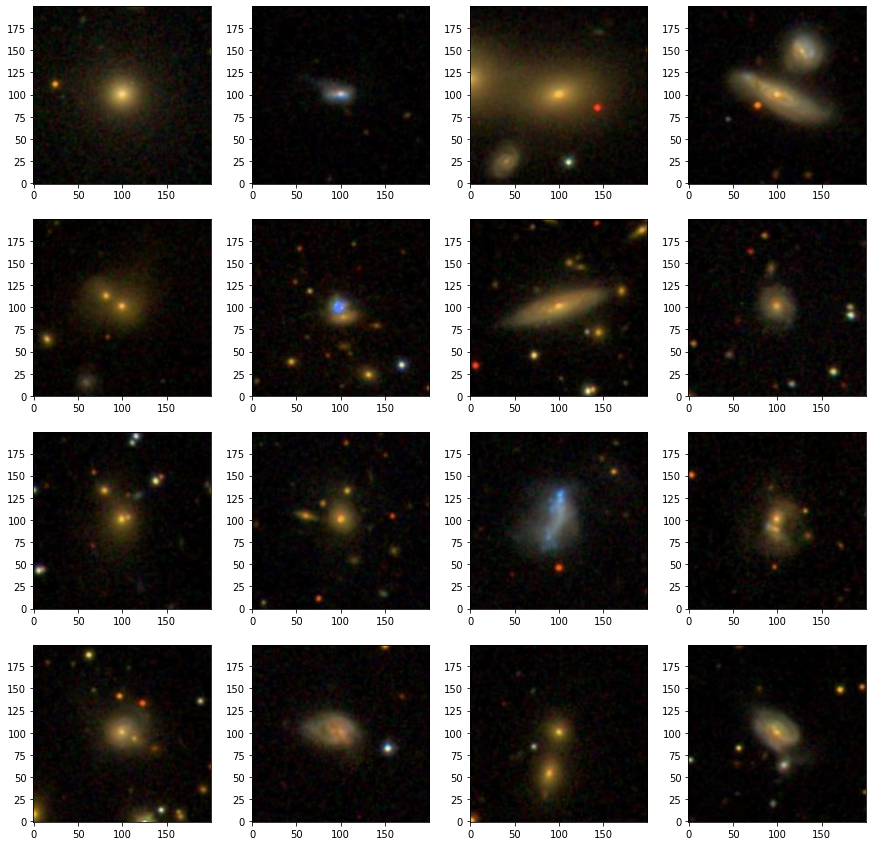

In [49]:
import SciServer.SkyServer as SkyServer
mergers = all_gals.query("As >= 0.2")
fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
pixelsize=.369
for i in range(16):
    filename = mergers["fname"].iloc[i]
    ra, dec = mergers["objra"].iloc[i], mergers["objdec"].iloc[i]
    #image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)
    #image = pmlsst.imageutils.maskstarsSEG(image)
#     scale = 2.*mergers["rmax"]/pixelsize/200
#     print(scale)
    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=200, height=200, scale=.3, dataRelease='DR16')
    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")